In [2]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(16,8))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p
import lin_lib as ll
import demodulation_lib as dl
from qubic.utils import progress_bar

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import scipy.signal as scsig
from scipy import interpolate

//anaconda/lib/python2.7/site-packages/pyoperators/utils/misc.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import cythonutils as cu
//anaconda/lib/python2.7/site-packages/pyfftw/__init__.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .pyfftw import (


importing qubicpack without pystudio


//anaconda/lib/python2.7/site-packages/healpy/sphtfunc.py:28: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _sphtools as _sphtools
//anaconda/lib/python2.7/site-packages/healpy/sphtfunc.py:28: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from . import _sphtools as _sphtools
//anaconda/lib/python2.7/site-packages/healpy/__init__.py:47: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._query_disc import query_disc, query_strip, query_polygon, boundaries
//anaconda/lib/python2.7/site-packages/healpy/__init__.py:47: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from ._query_disc import query_disc, query_strip, query_polygon, boundaries
//anaconda/lib/python2.7/site-packages/healpy/__init__.py:48: RuntimeWarning: numpy.dtype size changed, may indicate b

In [13]:
day = '2019-04-01'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.sort(glob.glob(data_dir+'*test_sw*'))
print (dirs)
print (len(dirs))

labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
print labels

thedir = dirs[0]
print(thedir)

['/qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open'
 '/qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close'
 '/qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close'
 '/qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close']
4
['test_sw11-14_all_open', 'test_sw11-14_11_close', 'test_sw11-14_14_close', 'test_sw11-14_11_14_close']
/qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open


## Reading Data for a given asic

In [14]:
AsicNum = 2
a = qp()
a.read_qubicstudio_dataset(thedir, asic=AsicNum)

Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic2-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic2-2019.04.01.182027.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/conf-asics-2019.

## Reading TES Data

Bad GPS Data!
ERROR! Bad GPS data.  Using sample rate to make a time axis.
20443


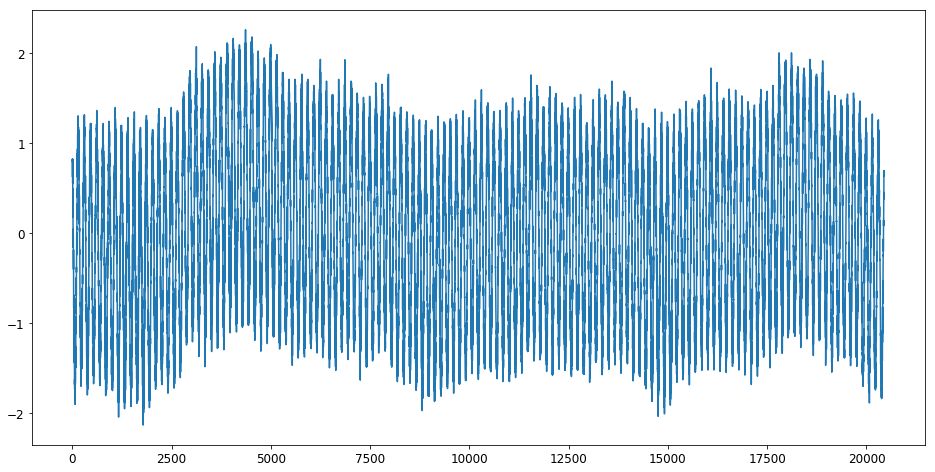

In [15]:
TESNum = 44
data = a.timeline(TES=TESNum)
#data = data[:18000]
t_data = a.timeline_timeaxis(axistype='pps')
print(len(t_data))
plot((data-np.mean(data))/np.std(data), label='Data')



## Let's use the amplitude of the first harmonic in the data as a measure of the signal

FREQ_SAMPLING = 156.25
Period_SAMPLING = 0.0064
Fitting with Minuit
correcting errorbars to have chi2/ndf=1 - correction = 2.73493205125e+18
[ 1.00000000e+00  1.07629585e-02  8.04475321e+10 -4.64653854e+07]
[0.00000000e+00 5.66085185e-05 3.80735373e+08 7.37851522e+07]
('Chi2=', 2.734932051247378e+18)
('ndf=', 22)
Amplitude = 80447532104.2


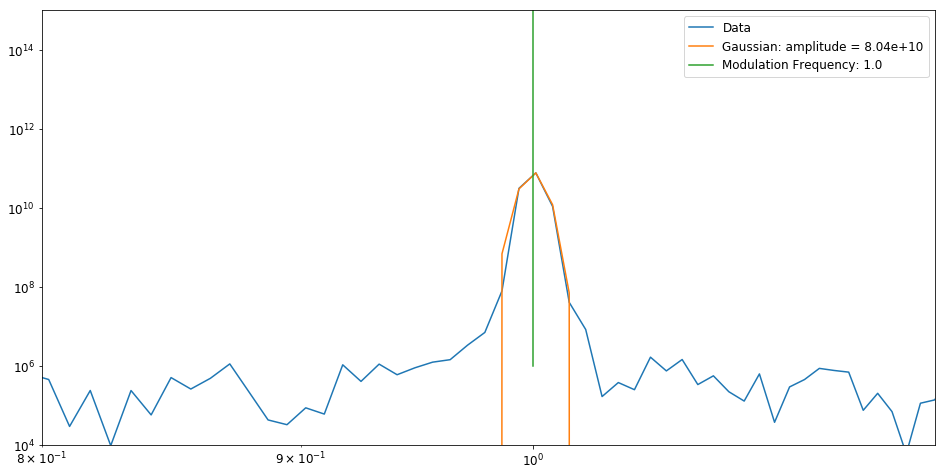

In [16]:
reload(dl)
period_sampling = t_data[1] - t_data[0]
FREQ_SAMPLING = 1. / (t_data[1] - t_data[0])
print('FREQ_SAMPLING = {}'.format(FREQ_SAMPLING))
print('Period_SAMPLING = {}'.format(period_sampling))

spectrum_f, freq_f = mlab.psd(data, Fs=FREQ_SAMPLING, NFFT=len(data), 
                              window=mlab.window_hanning)

freq_mod = 1.
okfit = np.abs(freq_f-freq_mod) < 0.1

guess = np.array([freq_mod, 0.01, np.max(spectrum_f[okfit]), np.median(spectrum_f[okfit])])
res = ft.do_minuit(freq_f[okfit], spectrum_f[okfit], np.ones(okfit.sum()), guess, 
                   functname=dl.gauss, fixpars=[1,0,0,0,0], 
                   nohesse=True,
                   force_chi2_ndf=True)

# Look at the amplitude of the peak
print('Amplitude = {}'.format(res[1][2]))

plot(freq_f, spectrum_f,label='Data')
plot(freq_f[okfit], dl.gauss(freq_f[okfit], res[1]), 
     label='Gaussian: amplitude = {0:5.3g}'.format(res[1][2]))
plot([freq_mod, freq_mod], [1e6, 1e15], label='Modulation Frequency: {}'.format(freq_mod))
yscale('log')
xscale('log')
xlim(freq_mod-0.2, freq_mod+0.2)
ylim(1e4, 1e15)
legend()

### Now do the same on both asics and all TES

In [22]:
allres = np.zeros((256,4))
allerr = np.zeros((256,4))
allamp1hz = np.zeros(256)

for AsicNum in [1,2]:
    a = qp()
    a.read_qubicstudio_dataset(thedir, asic=AsicNum)
    t_data = a.timeline_timeaxis(axistype='index')
    FREQ_SAMPLING = 1. / (t_data[1] - t_data[0])
    bar = progress_bar(128, 'ASIC #{}'.format(AsicNum))
    for TESNum in np.arange(128)+1:
        bar.update()
        TESindex = (TESNum-1) + 128 * (AsicNum-1)
        thedata = a.timeline(TES=TESNum)
        spectrum_f, freq_f = mlab.psd(thedata, Fs=FREQ_SAMPLING, NFFT=len(thedata), 
                              window=mlab.window_hanning)
        freq_mod = 1.
        allamp1hz[TESindex] = np.interp(freq_mod, freq_f, spectrum_f)
        okfit = np.abs(freq_f-freq_mod) < 0.1
        guess = np.array([freq_mod, 0.01, np.max(spectrum_f[okfit]), np.median(spectrum_f[okfit])])
        res = ft.do_minuit(freq_f[okfit], spectrum_f[okfit], np.ones(okfit.sum()), guess, 
                   functname=dl.gauss, fixpars=[1,0,0,0,0], 
                   nohesse=True, verbose=False,
                   force_chi2_ndf=True)
        allres[TESindex,:] = res[1]
        allerr[TESindex,:] = res[2]
        

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic1-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic1-2019.04.01.182027.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/conf-asics-2019.


Using TES temperature 372.9mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic2-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic2-2019.04.01.182027.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11

ASIC #1100%[=====================================================]Time: 0:00:40



Using TES temperature 372.9mK




ASIC #2100%[=====================================================]Time: 0:00:43


191660794287.16544
2604004120896.6577


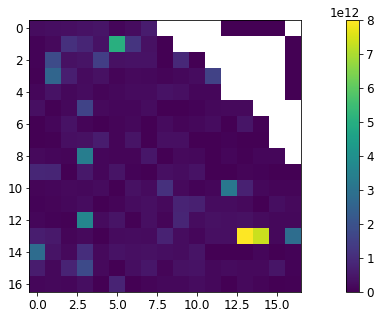

In [42]:
amps = allres[:,2]
img = ft.image_asics(all1=amps)
mm = np.median(amps)
print(mm)
ss = np.std(amps)
print(ss)
imshow(img, vmin = 0, vmax=mm+3*ss)
colorbar()

# Now loop on all files

In [43]:
allres_tot = np.zeros((len(dirs),256,4))
allerr_tot = np.zeros((len(dirs),256,4))
allamp_peak = np.zeros((len(dirs), 256))
from qubic.utils import progress_bar

for idir in xrange(len(dirs)):
    thedir = dirs[idir]
    for AsicNum in [1,2]:
        a = qp()
        a.read_qubicstudio_dataset(thedir, asic=AsicNum)
        t_data = a.timeline_timeaxis(axistype='index')
        FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
        bar = progress_bar(128, 'ASIC #{}'.format(AsicNum))
        for TESNum in np.arange(128)+1:
            bar.update()
            TESindex = (TESNum-1)+128*(AsicNum-1)
            thedata = a.timeline(TES=TESNum)
            spectrum_f, freq_f = mlab.psd(thedata, Fs=FREQ_SAMPLING, NFFT=len(thedata), 
                                  window=mlab.window_hanning)
            freq_mod = 1.
            allamp_peak[idir,TESindex] = np.interp(freq_mod, freq_f, spectrum_f)
            okfit = np.abs(freq_f-freq_mod) < 0.1
            guess = np.array([freq_mod, 0.01, np.max(spectrum_f[okfit]), np.median(spectrum_f[okfit])])
            res = ft.do_minuit(freq_f[okfit], spectrum_f[okfit], np.ones(okfit.sum()), guess, 
                       functname=dl.gauss, fixpars=[1,0,0,0,0], 
                       nohesse=True, verbose=False,
                       force_chi2_ndf=True)
            allres_tot[idir, TESindex,:] = res[1]
            allerr_tot[idir, TESindex,:] = res[2]

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic1-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic1-2019.04.01.182027.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/conf-asics-2019.


Using TES temperature 372.9mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic2-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Sums/science-asic2-2019.04.01.182027.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-MMR-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11-14_all_open/Hks/hk-intern-2019.04.01.182027.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.20.27__test_sw11

ASIC #1100%[=====================================================]Time: 0:00:39



Using TES temperature 372.9mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Sums/science-asic1-2019.04.01.182256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Sums/science-asic1-2019.04.01.182256.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Hks/hk-MMR-2019.04.01.182257.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Hks/hk-MMR-2019.04.01.182257.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Hks/hk-intern-2019.04.01.182256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Hks/hk-intern-2019.04.01.182256.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11

ASIC #2100%[=====================================================]Time: 0:00:43



Using TES temperature 374.2mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Sums/science-asic2-2019.04.01.182256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Sums/science-asic2-2019.04.01.182256.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Hks/hk-MMR-2019.04.01.182257.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Hks/hk-MMR-2019.04.01.182257.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Hks/hk-intern-2019.04.01.182256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11-14_11_close/Hks/hk-intern-2019.04.01.182256.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.22.56__test_sw11

ASIC #1100%[=====================================================]Time: 0:00:41



Using TES temperature 374.2mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Sums/science-asic1-2019.04.01.182540.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Sums/science-asic1-2019.04.01.182540.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Hks/hk-MMR-2019.04.01.182540.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Hks/hk-MMR-2019.04.01.182540.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Hks/hk-intern-2019.04.01.182540.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Hks/hk-intern-2019.04.01.182540.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11

ASIC #2100%[=====================================================]Time: 0:00:44



Using TES temperature 374.2mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Sums/science-asic2-2019.04.01.182540.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Sums/science-asic2-2019.04.01.182540.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Hks/hk-MMR-2019.04.01.182540.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Hks/hk-MMR-2019.04.01.182540.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Hks/hk-intern-2019.04.01.182540.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11-14_14_close/Hks/hk-intern-2019.04.01.182540.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.25.40__test_sw11

ASIC #1100%[=====================================================]Time: 0:00:39



Using TES temperature 374.2mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Sums/science-asic1-2019.04.01.182831.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Sums/science-asic1-2019.04.01.182831.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Hks/hk-MMR-2019.04.01.182831.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Hks/hk-MMR-2019.04.01.182831.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Hks/hk-intern-2019.04.01.182831.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Hks/hk-intern-2019.04.01.182831.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_1

ASIC #2100%[=====================================================]Time: 0:00:41



Using TES temperature 375.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Sums/science-asic2-2019.04.01.182831.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Sums/science-asic2-2019.04.01.182831.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Hks/hk-MMR-2019.04.01.182831.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Hks/hk-MMR-2019.04.01.182831.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Hks/hk-intern-2019.04.01.182831.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_18.28.31__test_sw11-14_11_14_close/Hks/hk-intern-2019.04.01.182831.fits
reading fits file: /qubic/Data/Calib-TD/2019-04-01/2019-04-01_1

ASIC #1100%[=====================================================]Time: 0:00:40



Using TES temperature 375.0mK




ASIC #2100%[=====================================================]Time: 0:00:42


In [26]:
print('Fini')
allres_tot.shape

Fini


(4, 256, 4)

## Amplitude on the focal plane for each file

In [47]:
allamp_peak

array([[1.40289556e+11, 1.81664811e+11, 1.87857927e+11, ...,
        1.11922006e+06, 1.21385451e+10, 9.22816725e+10],
       [1.00692914e+11, 1.47239216e+11, 1.61718585e+11, ...,
        2.45880241e+07, 1.30823368e+10, 8.79947444e+10],
       [8.54192544e+10, 2.07592553e+11, 2.28760256e+11, ...,
        1.91785034e+07, 2.46449142e+10, 1.00609736e+11],
       [1.75343987e+08, 1.46495866e+11, 1.80452830e+11, ...,
        3.69594676e+06, 2.75740316e+10, 7.87027929e+10]])

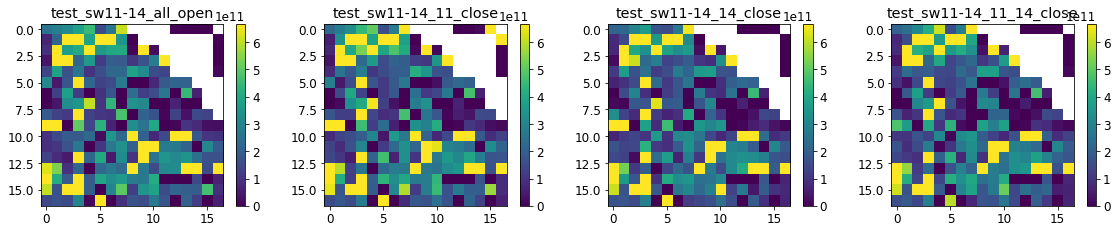

In [71]:
rc('figure',figsize=(16,12))
mm,ss = ft.meancut(allres_tot[:,:,2],3)
#mm,ss = ft.meancut(allres_tot,3)
allimg = np.zeros((len(dirs), 17, 17))
for i in xrange(len(dirs)):
    subplot(4,4,i+1)
    amps = allres_tot[i,:,2]
    #amps = allamp_peak[i,:]
    img = ft.image_asics(all1=amps)
    allimg[i,:,:] = img
    imshow(img, vmin=0, vmax=5*ss)
    colorbar()
    title(labels[i])
tight_layout()

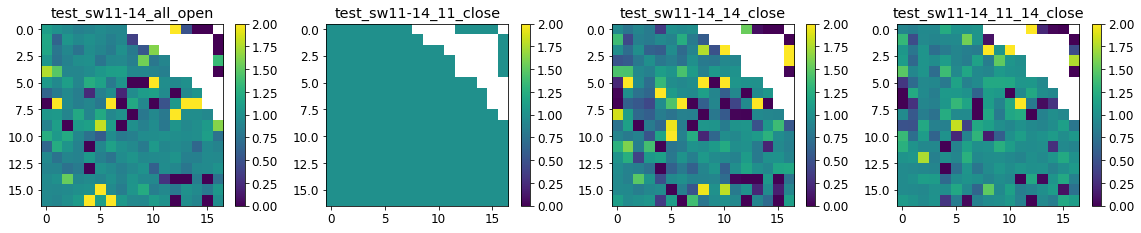

In [72]:
rc('figure',figsize=(16,12))
mm,ss = ft.meancut(allres_tot[:,:,2],3)
#mm,ss = ft.meancut(allamp_peak,3)
allimg = np.zeros((len(dirs), 17, 17))
for i in xrange(len(dirs)):
    amps = allres_tot[i,:,2]
    #amps = allamp_peak[i,:]
    allimg[i,:,:] = ft.image_asics(all1=amps)

iref = 1
for i in xrange(len(dirs)):
    subplot(4,4,i+1)
    imshow(allimg[i,:,:]/allimg[iref,:,:], vmin=0, vmax=2)
    colorbar()
    title(labels[i])
tight_layout()

In [73]:
amplitudes = allres_tot[:,:,2]

#### This is Stot
index_tot = 0

#### These are C-i, C-j and S-ij
index_11_14 = ['11_14', 1, 2, 3]

allsets = [index_11_14]

allimg = np.zeros((len(allsets), 17, 17))
for iset in xrange(len(allsets)):
    theset = allsets[iset]
    tit = theset[0]
    Stot = amplitudes[index_tot, :]
    #Stot = Stot / np.median(Stot)
    C_i = amplitudes[theset[1], :]
    #C_i = C_i / np.median(C_i) * 63./64
    C_j = amplitudes[theset[2], :]
    #C_j = C_j / np.median(C_j) * 63./64
    S_ij = amplitudes[theset[3], :]
    #S_ij = S_ij / np.median(S_ij) * 62./64
    fringe = Stot + S_ij - C_i - C_j
    allimg[iset,:,:] = ft.image_asics(all1=fringe)

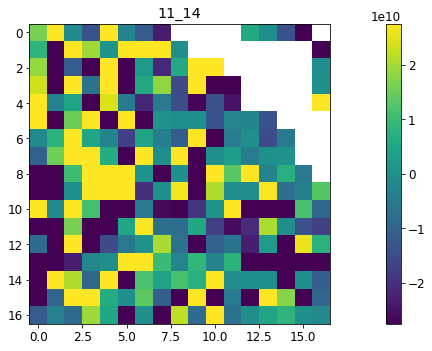

In [74]:
rc('figure',figsize=(16,5))
mm,ss = ft.meancut(allimg[np.isfinite(allimg)],3)
rng = ss
figure()
for i in xrange(len(allsets)):
    #subplot(2,2,i+1)
    imshow(allimg[i,:,:], vmin=-rng, vmax=rng)
    title(allsets[i][0])
    colorbar()

tight_layout()

## Try to normalize by all open

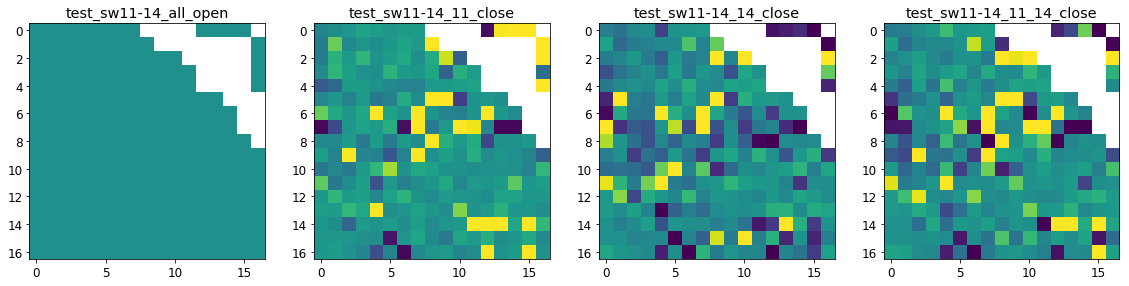

In [75]:
amps_ref = np.abs(allres_tot[0,:,2])
#amps_ref = allamp_peak[0,:]
img_ref = ft.image_asics(all1=amps_ref)

# do lists with amplitudes and images
allamps = []
allimages = []
for i in xrange(len(dirs)):
    amps = np.abs(allres_tot[i,:,2])
    #amps = allamp_peak[i,:]
    allamps.append(amps)
    
    img = ft.image_asics(all1=amps)
    allimages.append(img)
    
    subplot(1,4,i+1)
    imshow(img/img_ref, vmin=0, vmax=2)
    title(labels[i])
    
tight_layout()

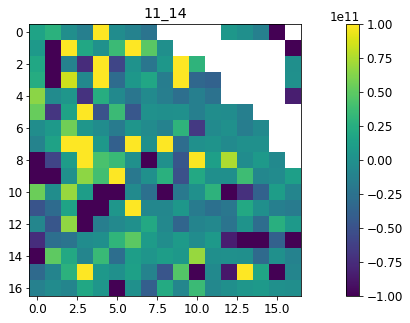

In [76]:
index_11_14 = ['11_14', 1, 2, 3]

allsets = [index_11_14]

S_tot = img_ref
figure()
for i in xrange(len(allsets)):
    theset = allsets[i]
    C_i = allimages[theset[1]]
    C_j = allimages[theset[2]]
    S_ij = allimages[theset[3]]
    fringe = S_tot + S_ij - C_i - C_j
    
    #subplot(2,2,i+1)
    #imshow(fringe/Stot, vmin=-1, vmax=1)
    imshow(fringe,vmin=-1e11,vmax=1e11)
    title(theset[0])
    colorbar()
    